In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from models import get_model_from_run
import time
import json
import os
import pandas as pd
import seaborn as sns

from tasks import InductionHopsFullSequenceTask

/var/folders/67/jn51thvj1pb07505h888bfww0000gn/T/ipykernel_33024/189996804.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
depths = [2, 3, 4, 5, 6]
widths = [4, 8]
sample_counts = [1000, 3000, -1]

In [3]:
# CHANGE THIS TO THE RELEVANT DEVICE
device = 'mps'

seq_len = 100
max_hops = 16
rng = np.random.RandomState(0)
task = InductionHopsFullSequenceTask(seq_len, char_tokens=4, min_hops=0, max_hops=max_hops, rng=rng)

# Model performance

The errors for the models trained by the authors are provided in `/local/errors.json`. If you wish to regenerate the errors on the trained models (or repalce them with your own trained models), set `generate_errors = True`.

In [13]:
generate_errors = False

In [14]:
if generate_errors:

    ## Add the directory names of your trained models here. Each tuple corresponds to (depth, width, samples), 
    # where -1 means the full dataset. The directory names are the ones output by the training script.
    model_dir_names = {
        (2, 4, 1000): "width4-depth2-samples1k",
        (2, 4, 3000): "width4-depth2-samples3k",
        (2, 4, 10000): "width4-depth2-samples10k",
        (2, 4, -1): "width4-depth2",
        (2, 8, -1): "width8-depth2",
        (3, 4, 1000): "width4-depth3-samples1k",
        (3, 4, 3000): "width4-depth3-samples3k",
        (3, 4, 10000): "width4-depth3-samples10k",
        (3, 4, -1): "width4-depth3",
        (3, 8, -1): "width8-depth3",
        (4, 4, 1000): "width4-depth4-samples1k",
        (4, 4, 3000): "width4-depth4-samples3k",
        (4, 4, 10000): "width4-depth4-samples10k",
        (4, 4, -1): "width4-depth4",
        (4, 8, -1): "width8-depth4",
        (5, 4, 1000): "width4-depth5-samples1k",
        (5, 4, 3000): "width4-depth5-samples3k",
        (5, 4, 10000): "width4-depth5-samples10k",
        (5, 4, -1): "width4-depth5",
        (5, 8, -1): "width8-depth5",
        (6, 4, 1000): "width4-depth6-samples1k",
        (6, 4, 3000): "width4-depth6-samples3k",
        (6, 4, 10000): "width4-depth6-samples10k",
        (6, 4, -1): "width4-depth6",
        (6, 8, -1): "width8-depth6",
    }

    models = {}
    for key, model_dir in model_dir_names.items():
        model_path = f"../models/induction_hops_full_seq/{model_dir}"
        models[key] = get_model_from_run(model_path, seq_len=seq_len, step=100000)[0].to(device)
        
    errors = {}
    samples_per_hop = 100
    blank_token_min = task.char_tokens + task.induction_tokens

    for h in range(max_hops+1):
        samples = task.get_batch(samples_per_hop, hops=h)
        input, output = samples[0].to(device), samples[1].to(device)
        preds = {}
        for key in models:
            t = time.time()
            preds[key] = models[key](input).argmax(dim=-1)
            print(f"Ran model {key} for {h} hops in {time.time() - t} seconds")
        
        for width, samples in [(4, 1000), (4, 3000), (4, 10000), (4, -1), (8, -1)]:
            for depth in depths:
                key = (depth, width, samples)
                errors[(key, h)] = (preds[key][output < blank_min] != output[output < blank_min]).float().mean().item() 

    # convert errors to a format that can saved as json
    errors_json = {str(key): value for key, value in errors.items()}

    # save errors as json
    with open("../local/errors.json", "w") as f:
        json.dump(errors_json, f)

else:
    # read errors from json
    with open("../local/errors.json", "r") as f:
        errors_json = json.load(f)

    # convert errors back to original format
    errors = {tuple(eval(key)): value for key, value in errors_json.items()}


In [15]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.format'] = 'pdf'

fig_sizes = {
    "body":  (6, 4),
    "appendix": (12, 6),
    "appendix-width": (12, 6),
    "appendix-1000": (12, 6),
    "appendix-3000": (12, 6),
}

In [22]:
def plot_error_k(loc):
    if loc == "appendix-1000":
        (width, samples) = (4, 1000)
    else:
        (width, samples) = (4, -1)

    fig, ax = plt.subplots(figsize=fig_sizes[loc])
    for depth in depths:
        hop_range = range(1,17)
        if loc == 'appendix-width':
            ax.plot(hop_range, [errors[((depth, width, samples), h)] for h in hop_range], label=f"$L={depth}, H = 4$", color=cm.gnuplot2((depth-2) / len(depths)), linestyle='--', alpha=0.25)
            ax.scatter(hop_range, [errors[((depth, 8, samples), h)] for h in hop_range], color=cm.gnuplot2((depth-2) / len(depths)), s=10)
            ax.plot(hop_range, [errors[((depth, 8, samples), h)] for h in hop_range], label=f"$L={depth}, H = 8$", color=cm.gnuplot2((depth-2) / len(depths)))
        elif loc == "appendix-3000":
            ax.plot(hop_range, [errors[((depth, width, 3000), h)] for h in hop_range], label=f"$L={depth}, n = 3000$", color=cm.gnuplot2((depth-2) / len(depths)))
            ax.scatter(hop_range, [errors[((depth, width, 3000), h)] for h in hop_range], color=cm.gnuplot2((depth-2) / len(depths)), s=10)
            ax.plot(hop_range, [errors[((depth, width, -1), h)] for h in hop_range], label=f"$L={depth}, n = \infty$", color=cm.gnuplot2((depth-2) / len(depths)), linestyle='--', alpha=0.25)
        elif loc == "appendix-1000":
            ax.plot(hop_range, [errors[((depth, width, 1000), h)] for h in hop_range], label=f"$L={depth}, n = 1000$", color=cm.gnuplot2((depth-2) / len(depths)))
            ax.scatter(hop_range, [errors[((depth, width, 1000), h)] for h in hop_range], color=cm.gnuplot2((depth-2) / len(depths)), s=10)
            ax.plot(hop_range, [errors[((depth, width, -1), h)] for h in hop_range], label=f"$L={depth}, n = \infty$", color=cm.gnuplot2((depth-2) / len(depths)), linestyle='--', alpha=0.25)
        else:
            ax.scatter(hop_range, [errors[((depth, width, samples), h)] for h in hop_range], color=cm.gnuplot2((depth-2) / len(depths)), s=10)
            ax.plot(hop_range, [errors[((depth, width, samples), h)] for h in hop_range], label=f"$L={depth}$", color=cm.gnuplot2((depth-2) / len(depths)))
    ax.set_xlabel("$k$")
    if loc == "body":
        ax.set_ylabel("Error")
    else:
        ax.set_ylabel(r"Error: $\mathtt{{err}}_n^k(T)$")
    titles = {
        "body": r"$L$-layer transformer token-wise classification error on $\mathrm{hop}_k$",
        "appendix": r"Evaluation of $L$-depth, 4-headed, infinite-sample intransformers on $\mathrm{{hop}}_k$",
        "appendix-width": r"Evaluation of $L$-depth, $H$-headed, infinite-sample intransformers on $\mathrm{{hop}}_k$",
        "appendix-1000": r"Evaluation of $L$-depth, 4-headed, $n$-sample intransformers on $\mathrm{{hop}}_k$",
        "appendix-3000": r"Evaluation of $L$-depth, 4-headed, $n$-sample intransformers on $\mathrm{{hop}}_k$",
    }
    ax.set_title(titles[loc])
    ax.set_xscale('log', base=2)
    ax.set_xticks([1, 2, 4, 8, 16])
    ax.set_xticklabels([1, 2, 4, 8, 16])

    ax.legend()
    plt.show()


<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:21: SyntaxWarning: invalid escape sequence '\i'
/var/folders/67/jn51thvj1pb07505h888bfww0000gn/T/ipykernel_55585/2439952501.py:17: SyntaxWarning: invalid escape sequence '\i'
  ax.plot(hop_range, [errors[((depth, width, -1), h)] for h in hop_range], label=f"$L={depth}, n = \infty$", color=cm.gnuplot2((depth-2) / len(depths)), linestyle='--', alpha=0.25)
/var/folders/67/jn51thvj1pb07505h888bfww0000gn/T/ipykernel_55585/2439952501.py:21: SyntaxWarning: invalid escape sequence '\i'
  ax.plot(hop_range, [errors[((depth, width, -1), h)] for h in hop_range], label=f"$L={depth}, n = \infty$", color=cm.gnuplot2((depth-2) / len(depths)), linestyle='--', alpha=0.25)


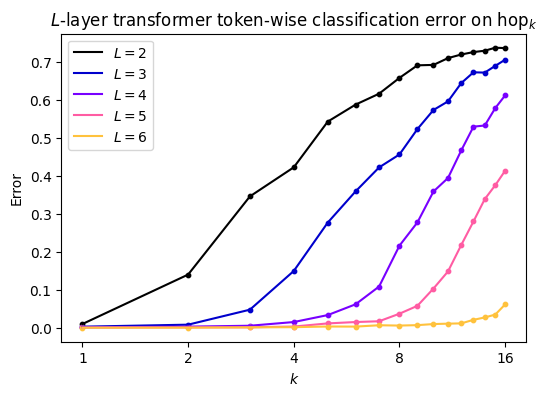

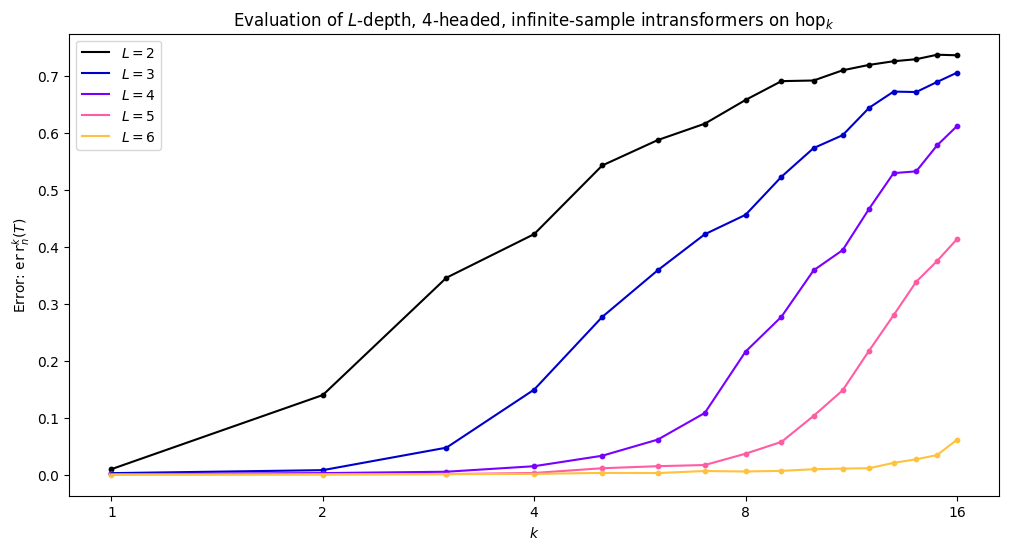

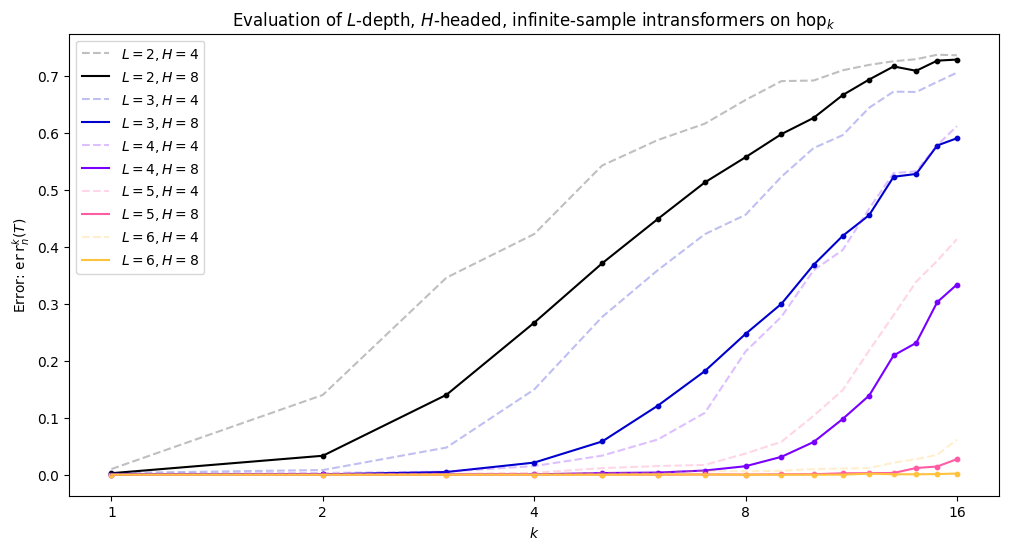

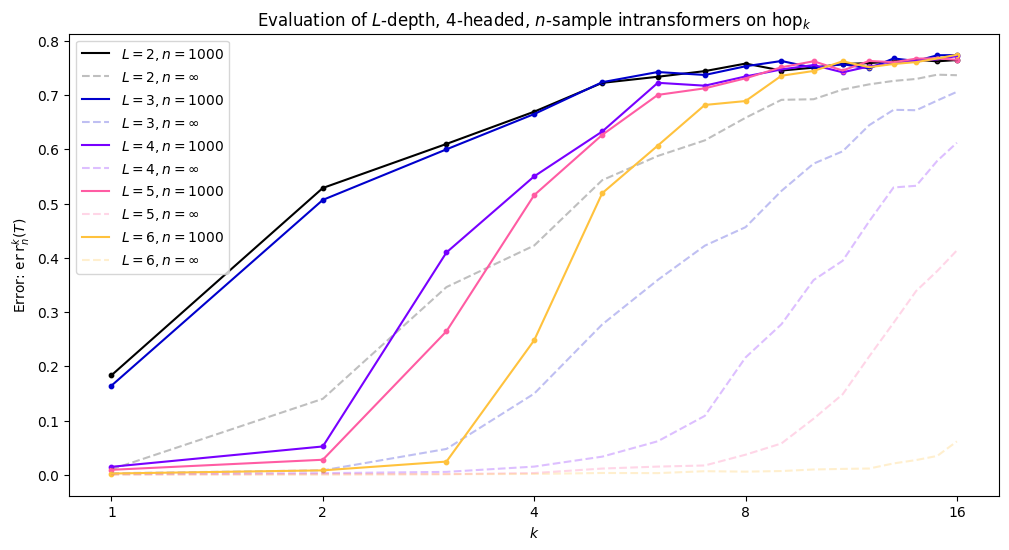

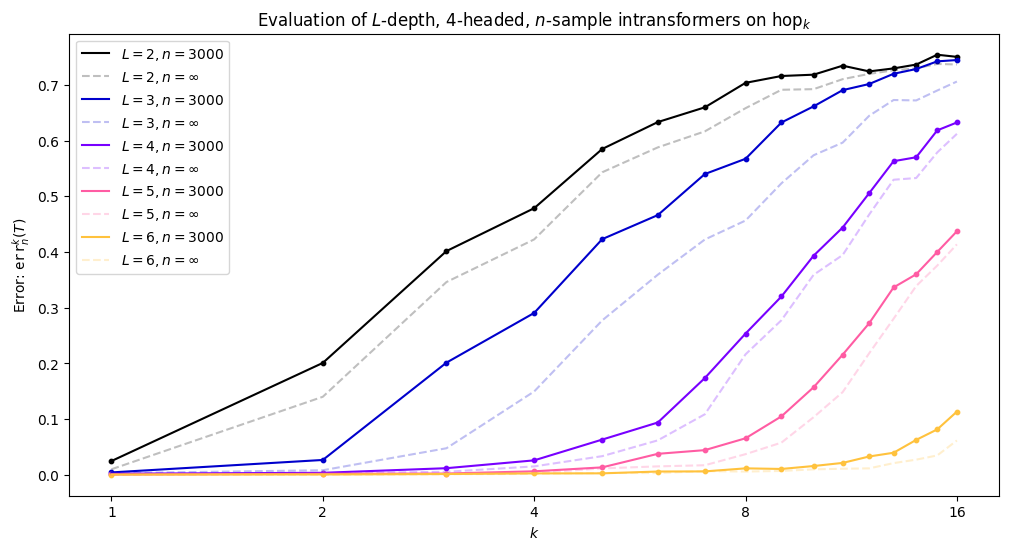

In [23]:
plot_error_k("body")
plot_error_k("appendix")
plot_error_k("appendix-width")
plot_error_k("appendix-1000")
plot_error_k("appendix-3000")

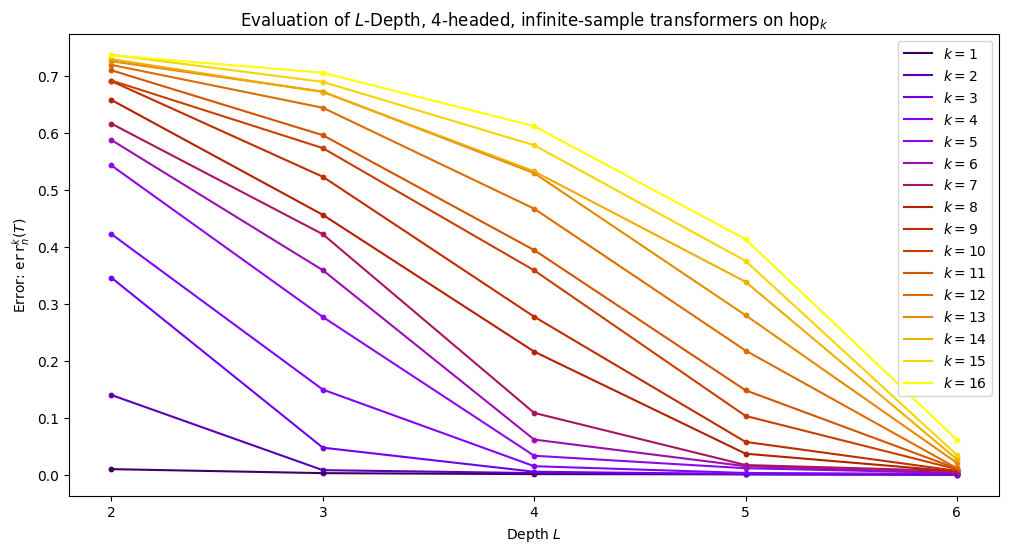

In [27]:
(width, samples) = (4, -1)

fig, ax = plt.subplots(figsize=fig_sizes['appendix'])
for h in range(1,max_hops+1):
    ax.scatter(depths, [errors[((depth, width, samples), h)] for depth in depths], color=cm.gnuplot(h / max_hops), s=10)
    ax.plot(depths, [errors[((depth, width, samples), h)] for depth in depths], label=r"$k={h}$".format(h=h), color=cm.gnuplot(h / max_hops))
ax.set_xlabel(r"Depth $L$")
ax.set_ylabel(r"Error: $\mathtt{{err}}_n^k(T)$")
ax.set_title(r"Evaluation of $L$-Depth, 4-headed, infinite-sample transformers on $\mathrm{{hop}}_k$")
ax.set_xticks(depths)
ax.legend()
plt.show()


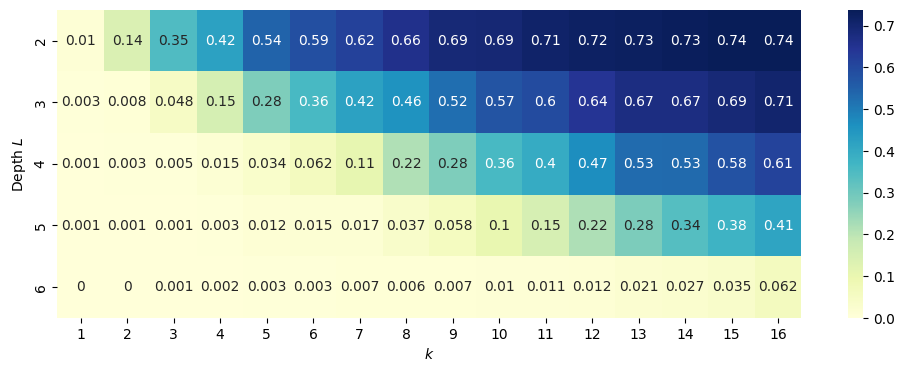

In [29]:
df = pd.DataFrame({f"{h}": [errors[((depth, 4, -1), h)] for depth in depths] for h in range(1,17)}, index=depths)
df.index.name = "Depth $L$"
df.columns.name = "$k$"
df = df.round(3)

fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(df, annot=True, cmap="YlGnBu", ax=ax)
plt.show()
